### Created by Peeraya Khantaruangsakul 63070501054

### Import dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from textacy.extract.kwic import keyword_in_context
import random
#do not show warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_table('https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/193c79c7d94973f2398e67da8d20bf7a535f7f40/data/un-general-debates/un-general-debates-blueprint.csv.gz', compression='gzip', sep=',', quotechar='"', error_bad_lines=False)

### Filter country_name = United States

In [3]:
df['length'] = df['text'].str.len()
df.columns

Index(['session', 'year', 'country', 'country_name', 'speaker', 'position',
       'text', 'length'],
      dtype='object')

In [4]:
df_US = df[df['country_name'] == 'United States']

### Check missing data

In [5]:
df_US.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 65 to 7495
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       46 non-null     int64 
 1   year          46 non-null     int64 
 2   country       46 non-null     object
 3   country_name  46 non-null     object
 4   speaker       46 non-null     object
 5   position      32 non-null     object
 6   text          46 non-null     object
 7   length        46 non-null     int64 
dtypes: int64(3), object(5)
memory usage: 3.2+ KB


In [6]:
df_US.describe().T

,count,mean,std,min,25%,50%,75%,max
session,46.0,47.500000,13.422618,25.0,36.25,47.5,58.75,70.0
year,46.0,1992.500000,13.422618,1970.0,1981.25,1992.5,2003.75,2015.0
length,46.0,23190.391304,7017.578473,11105.0,17223.50,21918.5,28029.50,43287.0


In [7]:
df_US.describe(include=['O']).T

,count,unique,top,freq
country,46,1,USA,46
country_name,46,1,United States,46
speaker,46,32,Barack Obama,7
position,32,4,President,26
text,46,46,1.\t It is my privilege to extend to you once ...,1


In [8]:
df_US.isna().sum()

session          0
year             0
country          0
country_name     0
speaker          0
position        14
text             0
length           0
dtype: int64

### Distribution analysis

<AxesSubplot: >

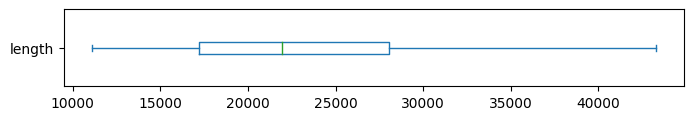

In [9]:
df_US['length'].plot(kind='box', vert=False, figsize=(8,1))

<AxesSubplot: ylabel='Frequency'>

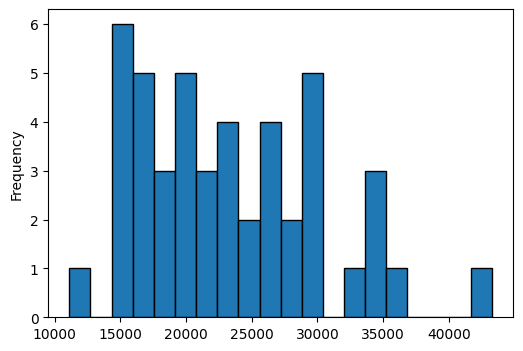

In [10]:
df_US['length'].plot(kind='hist', bins=20, figsize=(6,4), edgecolor='black')

### Clean text column

In [11]:
# Change lowercase
df_US['text'] = df_US['text'].str.lower()

In [12]:
def remove_special_characters(text):
    return re.sub('[^A-Za-z0-9]+', ' ', text)

In [13]:
df_US['text'] = df_US['text'].apply(remove_special_characters).str.strip()

In [14]:
stopwords = set(nltk.corpus.stopwords.words('english'))
def remove_stop(tokens):
    return [w for w in tokens if w not in stopwords]

In [15]:
df_US['tokens'] = df_US['text'].apply(word_tokenize)
df_US['tokens_stopword'] = df_US['tokens'].apply(remove_stop)

In [16]:
df_US['length_stopword'] = df_US['tokens_stopword'].str.len()

In [17]:
tokens = df_US['tokens'].explode().values
counter = Counter(tokens)
counter.most_common(10)


[('the', 12117),
 ('of', 6979),
 ('and', 6237),
 ('to', 6024),
 ('in', 3697),
 ('a', 3253),
 ('that', 2914),
 ('we', 2886),
 ('is', 2085),
 ('for', 1867)]

In [18]:
tokens_stop = df_US['tokens_stopword'].explode().values
counter_stop = Counter(tokens_stop)
counter_stop.most_common(10)

[('united', 1518),
 ('nations', 1470),
 ('world', 1063),
 ('states', 850),
 ('must', 775),
 ('peace', 758),
 ('people', 728),
 ('us', 487),
 ('new', 482),
 ('international', 480)]

In [19]:
df_US.head()

,session,year,country,country_name,speaker,position,text,length,tokens,tokens_stopword,length_stopword
65,25,1970,USA,United States,Mr. YOST,NaN,1 it is my privilege to extend to you once aga...,34911,"[1, it, is, my, privilege, to, extend, to, you...","[1, privilege, extend, warm, congratulations, ...",3070
179,26,1971,USA,United States,Mr. ROGERS,NaN,mr president i should like first of all to ass...,29393,"[mr, president, i, should, like, first, of, al...","[mr, president, like, first, associate, previo...",2579
304,27,1972,USA,United States,Mr. Rogers,NaN,during the past few years the world has made r...,23365,"[during, the, past, few, years, the, world, ha...","[past, years, world, made, remarkable, advance...",2089
424,28,1973,USA,United States,Kissinger,NaN,35 i should like to add my congratulations to ...,16222,"[35, i, should, like, to, add, my, congratulat...","[35, like, add, congratulations, well, express...",1452
554,29,1974,USA,United States,Mr. Kissinger,NaN,last year at the previous session 2124th meeti...,26413,"[last, year, at, the, previous, session, 2124t...","[last, year, previous, session, 2124th, meetin...",2360


### Bigram

In [20]:
# don't have stopword
token_words = [x for x in ngrams(tokens_stop, n = 2)]

In [21]:
concatenated_bigrams = [' '.join(x) for x in token_words]

### Frequency

In [22]:
counter_bigrams = Counter(concatenated_bigrams)
counter_bigrams.most_common(10)

[('united nations', 786),
 ('united states', 700),
 ('human rights', 170),
 ('soviet union', 140),
 ('security council', 135),
 ('middle east', 121),
 ('nuclear weapons', 115),
 ('general assembly', 108),
 ('let us', 98),
 ('years ago', 79)]

In [23]:
top_10_bigrams = [bigram[0] for bigram in counter_bigrams.most_common(10)]
all_bigrams = [bigram[0] for bigram in counter_bigrams.most_common()]
concatenated_bigrams_top_10 = [bigram for bigram in concatenated_bigrams if bigram in top_10_bigrams]
concatenated_all_bigrams = [bigram for bigram in concatenated_bigrams if bigram in all_bigrams]

### word cloud

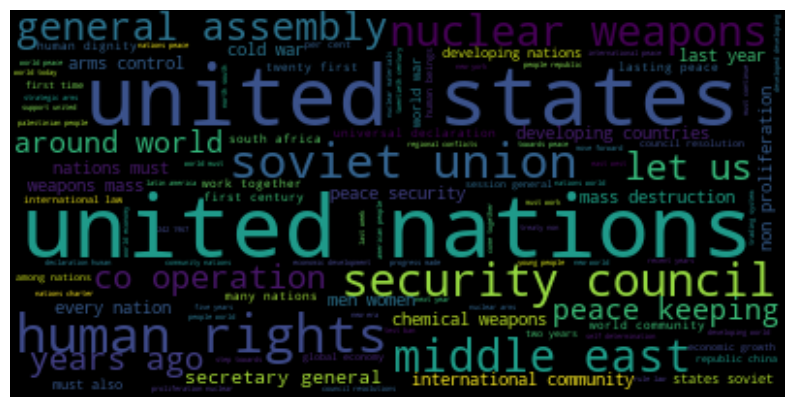

In [24]:
wc = WordCloud(background_color="black", max_words=100)
wc.generate_from_frequencies(counter_bigrams)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bigram trend

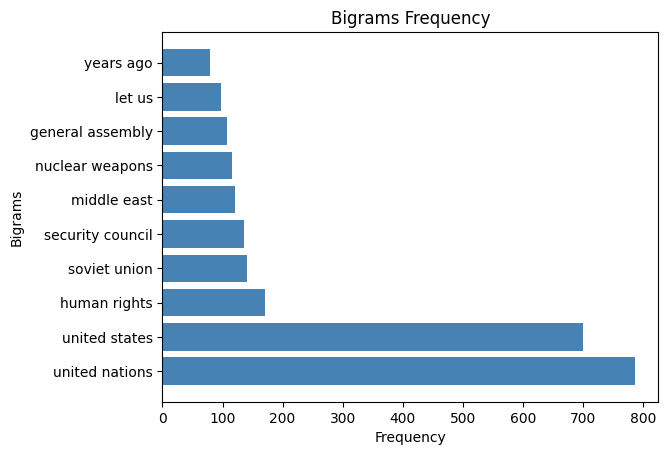

In [25]:
most_common_bigrams = counter_bigrams.most_common(10)
bigrams, frequencies = zip(*most_common_bigrams)

plt.barh(bigrams, frequencies, color='steelblue')
plt.ylabel('Bigrams')
plt.xlabel('Frequency')
plt.title('Bigrams Frequency')
plt.show()

In [26]:
def kwic(doc_series, keyword, window=35, print_samples=5):
  def add_kwic(text):
    kwic_list.extend(keyword_in_context(text,keyword, ignore_case=True, window_width=window))
  
  kwic_list = []
  doc_series.map(add_kwic)

  if print_samples is None or print_samples==0:
    return kwic_list
  else:
    return len(kwic_list)

In [27]:
keywords = top_10_bigrams
bigrams_data = []
for year in df['year'].unique():
  for keyword in keywords:
    bigrams_data.append([year, keyword, kwic(df_US[df_US['year']==year]['text'], keyword, print_samples=1)])

bigrams_df = pd.DataFrame(bigrams_data, columns=['year', 'keyword', 'count'])
bigrams_df = bigrams_df.pivot(index='year', columns='keyword', values='count')
bigrams_df = bigrams_df.reset_index() 

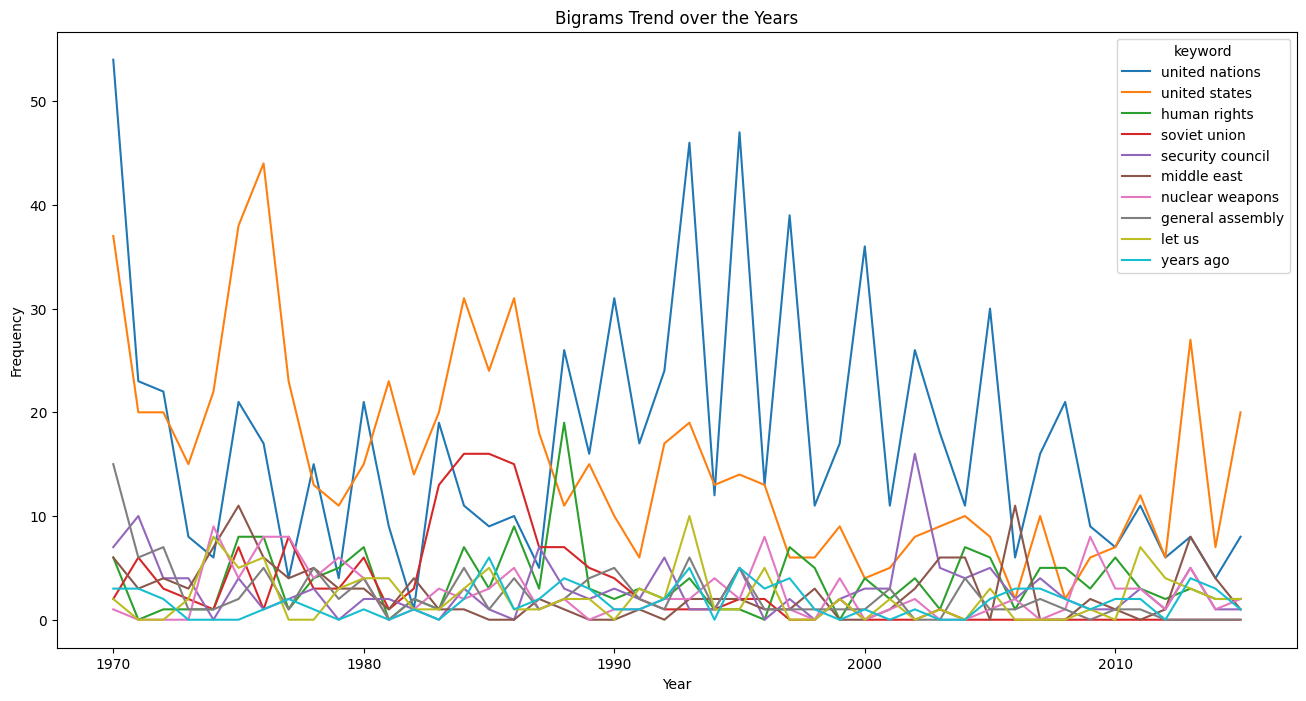

In [28]:
bigrams_df.plot(x='year', y=keywords, kind='line', figsize=(16, 8))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Bigrams Trend over the Years')
plt.show()

In [29]:
key = ['sustainable energy', 'poverty', 'wars', 'united states', 'privilege', 'future']
word_data = []
for year in df['year'].unique():
  for keyword in key:
    word_data.append([year, keyword, kwic(df[df['year']==year]['text'], keyword, print_samples=1)])

trend_df = pd.DataFrame(word_data, columns=['year', 'keyword', 'count'])
trend_df = trend_df.pivot(index='year', columns='keyword', values='count')
trend_df = trend_df.reset_index()

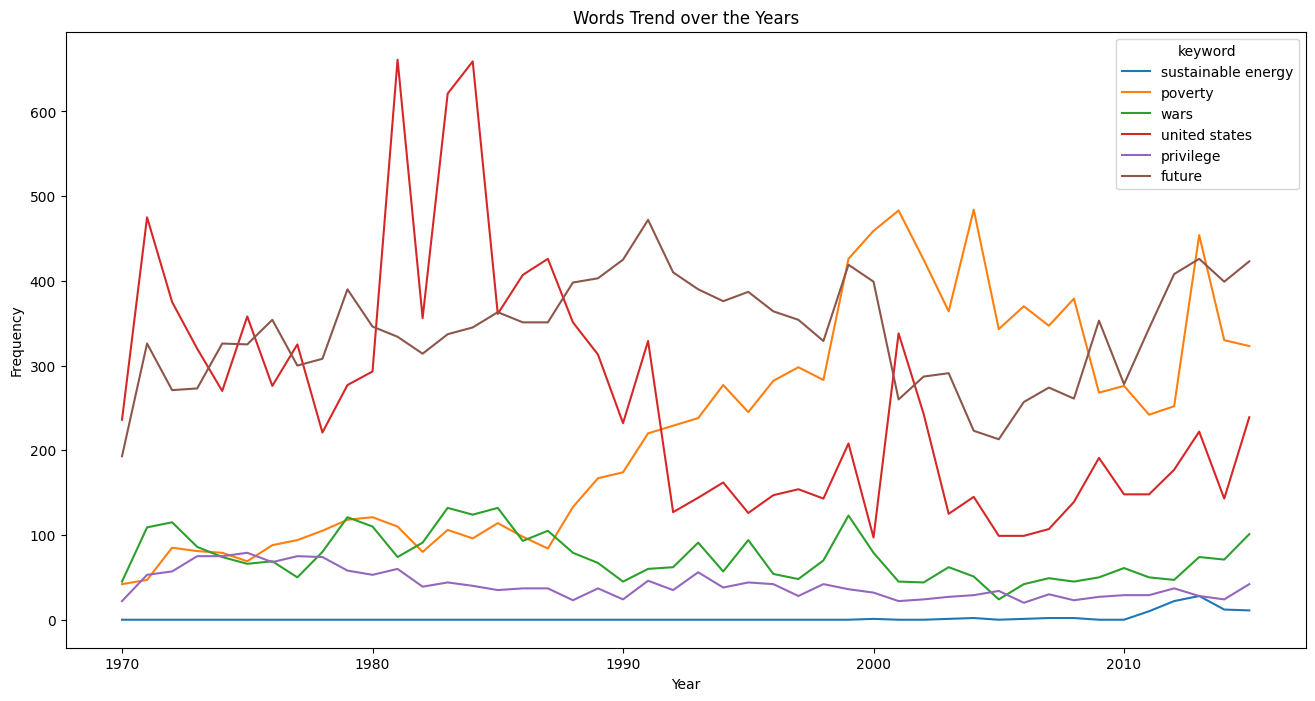

In [30]:
trend_df.plot(x='year', y=key, kind='line', figsize=(16, 8))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Words Trend over the Years')
plt.show()
